In [6]:
from os import listdir
from os.path import isfile, join

from pathlib import Path

import ast

import networkx as nx

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

from helpers import input_graph, input_generated_graph_and_processors_from_file

%matplotlib inline

./results/GAP_metis/weighted/rand/dag26.txt
./results/GAP_metis/unweighted/rand/dag26.txt
./results/GAP2_metis/weighted/rand/dag26.txt
./results/GAP2_metis/unweighted/rand/dag26.txt


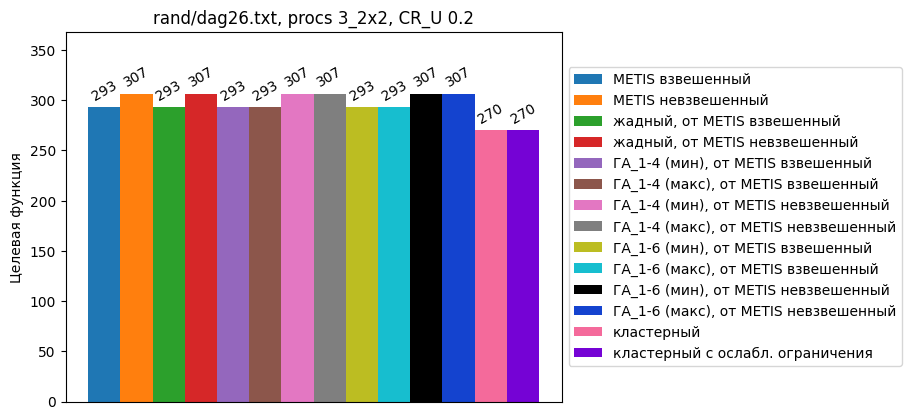

[293.33333333 306.66666667 293.33333333 306.66666667 293.33333333
 293.33333333 306.66666667 306.66666667 293.33333333 293.33333333
 306.66666667 306.66666667 270.         270.        ]


In [ ]:
graph_name = 'triangle/triadag10_5.txt'
graph_name = 'sausages/dagA15.txt'
# graph_name = 'testing_graphs/16_envelope_mk_rand.txt'
# graph_name = 'testing_graphs/16_envelope_mk_eq.txt'
graph_name = 'rand/dag26.txt'

# pg_name = '3_2x1.txt'
pg_name = '3_2x2.txt'
# pg_name = '3_2x3.txt'
# pg_name = '3_2x4.txt'
# pg_name = '3_2x5.txt'
# pg_name = '1_4x1.txt'
# pg_name = '1_4x2.txt'
# pg_name = '1_4x3.txt'
# pg_name = '1_4x4.txt'
# pg_name = '1_4x5.txt'
# pg_name = '5_4_3_2x1.txt'
# pg_name = '5_4_3_2x2.txt'
# pg_name = '5_4_3_2x3.txt'
# pg_name = '5_4_3_2x4.txt'
# pg_name = '5_4_3_2x5.txt'


cr_u = 0.35
# cr_u = 0.2
cr_u = 0.4
# cr_u = 0.45
iter_u = 100
# iter_u = 50
# cr_u = 0.3
# cr_u = 0.45
# cr_u = 0.4
cr_u = 0.2

# cr_u_list = [0.2, 0.3, 0.4]

bars = []

names = [
    'METIS взвешенный',
    'METIS невзвешенный',
    'жадный, от METIS взвешенный',
    'жадный, от METIS невзвешенный',
    'ГА_1-4 (мин), от METIS взвешенный',
    'ГА_1-4 (макс), от METIS взвешенный',
    'ГА_1-4 (мин), от METIS невзвешенный',
    'ГА_1-4 (макс), от METIS невзвешенный',
    'ГА_1-6 (мин), от METIS взвешенный',
    'ГА_1-6 (макс), от METIS взвешенный',
    'ГА_1-6 (мин), от METIS невзвешенный',
    'ГА_1-6 (макс), от METIS невзвешенный',
    'кластерный',
    'кластерный с ослабл. ограничения',
]

# for cr_u in cr_u_list:
paths = [
    './results2/metis_with_pg/weighted/{}',
    './results2/metis_with_pg/unweighted/{}',
    './results/greed/weighted/{}',
    './results/greed/unweighted/{}',
]
for path in paths:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        for line in file.readlines():
            _, pg, _, cr, cr_lim, f_val, _ = line.split(maxsplit=6)
            # cr = float(cr)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim:
                bars.append(f_val)
                break

paths_genetics = [
    './results/GAP_metis/weighted/{}',
    './results/GAP_metis/unweighted/{}',
    './results/GAP2_metis/weighted/{}',
    './results/GAP2_metis/unweighted/{}',
]
for path in paths_genetics:
    g_min = 1e12
    g_max = 0
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            _, pg, r2, max_iter, cr, _, cr_lim, f_val, _ = line.split(maxsplit=8)
            # cr = float(cr)
            max_iter = int(max_iter)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim and iter_u == max_iter:
                # print(f_val)
                g_min = min(g_min, f_val)
                g_max = max(g_max, f_val)

        bars.append(g_min)
        bars.append(g_max)

paths = [
    './results2/MK_greed_greed_weighted/weighted/{}',
    './results2/MK_greed_greed_with_geq_cr/weighted/{}',
]
for path in paths:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        for line in file.readlines():
            _, pg, _, cr, cr_lim, f_val, _ = line.split(maxsplit=6)
            # cr = float(cr)
            cr_lim = float(cr_lim)
            f_val = float(f_val)

            if pg_name == pg and cr_u == cr_lim:
                bars.append(f_val)
                break

x = np.arange(len(bars))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

bars = np.array(bars)
if 'rand' in graph_name:
    bars = (bars / 16384) * 10

fig, ax = plt.subplots()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#1443cf', '#f46a9b', '#7503d5']

for attribute, measurement, color in zip(names, bars, colors):
    offset = width * multiplier
    rects = ax.bar(offset, measurement, width, label=attribute, color=color)
    ax.bar_label(rects, padding=3, rotation=30, fmt='%.0f')
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Целевая функция')
# ax.set_title(f'{graph_name.strip(".txt").split("/")[-1]}')
# ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}')
# ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}, ITER_MAX {iter_u}')
ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.removesuffix(".txt")}, CR_U {cr_u}')
# ax.set_xticks(x + width, species)
ax.set_xticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, int(max(filter(lambda x: x < 1e7, bars))*1.2))
plt.show()

print(bars)

./results/GAP_metis/weighted/sausages/dagA15.time
./results/GAP_metis/unweighted/sausages/dagA15.time
./results/GAP2_metis/weighted/sausages/dagA15.time
./results/GAP2_metis/unweighted/sausages/dagA15.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagA15.time
./results2/MK_greed_greed_with_geq_cr/weighted/sausages/dagA15.time


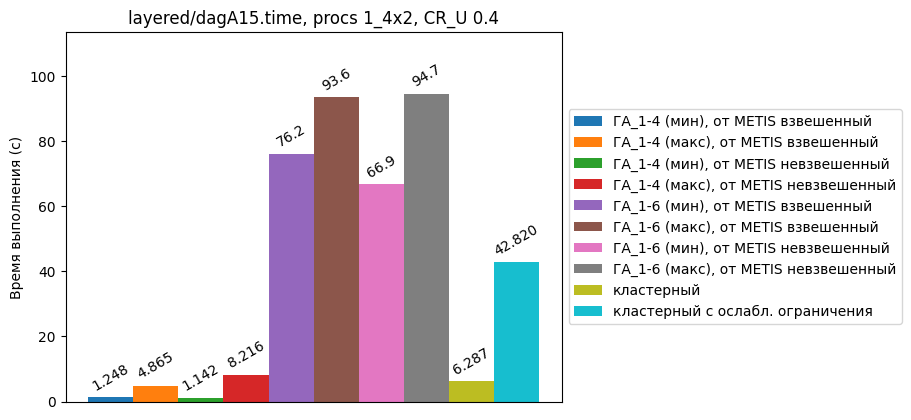

[ 1.24815536  4.86521649  1.14205074  8.21649432 76.18079948 93.566746
 66.87251854 94.70639682  6.28667283 42.82017159]


In [21]:
graph_name = 'sausages/dagA15.time'
# graph_name = 'triangle/triadag10_5.time'

# pg_name = '5_4_3_2x5.txt'
pg_name = '1_4x2.txt'


# cr_u = 0.35
cr_u = 0.4
iter_u = 100


bars = []

names = [
    'ГА_1-4 (мин), от METIS взвешенный',
    'ГА_1-4 (макс), от METIS взвешенный',
    'ГА_1-4 (мин), от METIS невзвешенный',
    'ГА_1-4 (макс), от METIS невзвешенный',
    'ГА_1-6 (мин), от METIS взвешенный',
    'ГА_1-6 (макс), от METIS взвешенный',
    'ГА_1-6 (мин), от METIS невзвешенный',
    'ГА_1-6 (макс), от METIS невзвешенный',
    'кластерный',
    'кластерный с ослабл. ограничения',
]


paths_genetics = [
    './results/GAP_metis/weighted/{}',
    './results/GAP_metis/unweighted/{}',
    './results/GAP2_metis/weighted/{}',
    './results/GAP2_metis/unweighted/{}',
]
for path in paths_genetics:
    g_min = 1e12
    g_max = 0
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            _, pg, cr_lim, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                # print(f_val)
                g_min = min(g_min, time)
                g_max = max(g_max, time)

        bars.append(g_min)
        bars.append(g_max)

paths = [
    './results2/MK_greed_greed_weighted/weighted/{}',
    './results2/MK_greed_greed_with_geq_cr/weighted/{}',
]
for path in paths:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        # dagA15.txt 5_4_3_2x5.txt 0.35 50 1716295898.9507778 0.16112923622131348 
        for line in file.readlines():
            _, pg, cr_lim, n, start_time, time = line.split()
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                bars.append(time)
                break

x = np.arange(len(bars))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

# bars = list(map(lambda x: round(x, 1) if x > 100 else x, bars))

bars = np.array(bars)
if 'rand' in graph_name:
    bars = (bars / 16384) * 10

fig, ax = plt.subplots()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#1443cf', '#f46a9b', '#7503d5']

for attribute, measurement, color in zip(names, bars, colors):
    offset = width * multiplier
    rects = ax.bar(offset, measurement, width, label=attribute, color=color)
    fmt = '%.3f' if measurement < 60 else '%.1f'
    ax.bar_label(rects, padding=3, rotation=30, fmt=fmt)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Время выполнения (с)')
ax.set_title(f'{graph_name.replace("sausages", "layered")}, procs {pg_name.strip(".txt")}, CR_U {cr_u}')
ax.set_xticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
ax.set_ylim(0, max(bars)*1.2)
plt.show()

print(bars)

./results/greed/weighted/{}
./results/greed/weighted/rand/dag26.time
./results/greed/weighted/{}
./results/greed/weighted/rand/dag15.time
./results/greed/weighted/{}
./results/greed/weighted/rand/dag16.time
./results/greed/weighted/{}
./results/greed/weighted/rand/dag13.time
./results/greed/weighted/{}
./results/greed/weighted/rand/dag0.time
[0.0008645057678222656, 0.0014007091522216797, 0.0026276111602783203, 0.001932382583618164, 0.002126455307006836]
./results2/MK_greed_greed_weighted/weighted/rand/dag26.time
./results2/MK_greed_greed_weighted/weighted/rand/dag15.time
./results2/MK_greed_greed_weighted/weighted/rand/dag16.time
./results2/MK_greed_greed_weighted/weighted/rand/dag13.time
./results2/MK_greed_greed_weighted/weighted/rand/dag0.time
[1.4194881916046143, 3.4700284004211426, 6.405776739120483, 8.710006952285767, 11.681722402572632]
./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag26.time
./results2/MK_greed_greed_with_geq_cr/weighted/rand/dag15.time
./results2/MK_gree

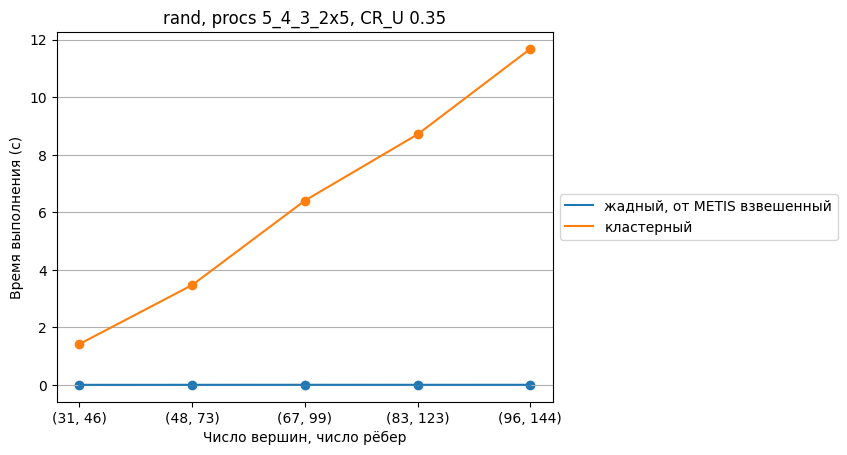

In [ ]:
graphs = [
    # 'testing_graphs/16_envelope_mk_eq.time',
    # 'testing_graphs/16_envelope_mk_rand.time',
    # 'testing_graphs/64_envelope_mk_eq.time',
    # 'testing_graphs/64_envelope_mk_rand.time',
    'rand/dag26.time',
    'rand/dag15.time',
    'rand/dag16.time',
    'rand/dag13.time',
    'rand/dag0.time',
    # 'sausages/dagA15.time',
    # 'sausages/dagH28.time',
    # 'sausages/dagK43.time',
    # 'sausages/dagN19.time',
    # 'sausages/dagR49.time',
    # 'triangle/triadag10_5.time',
    # 'triangle/triadag15_4.time',
    # 'triangle/triadag20_5.time',
    # 'triangle/triadag25_0.time',
    # 'triangle/triadag30_7.time',
]

# paths = [
#     './results/greed/weighted/{}',
#     './results2/MK_greed_greed_weighted/weighted/{}',
#     './results2/MK_greed_greed_with_geq_cr/weighted/{}',
# ]

labels = []
y = []


pg_name = '5_4_3_2x5.txt'
# pg_name = '1_4x2.txt'


cr_u = 0.35
# cr_u = 0.4

greed_y = []
greed_x = []
path = './results/greed/weighted/{}'
for graph_name in graphs:
    print(path)
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            # triadag10_5.txt 5_4_3_2x5.txt 0.35 55 1716289529.4229527 1.0220365524291992
            _, pg, cr_lim, n, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            n = int(n)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                greed_y.append(time)
        
                graph_path = f'./data/{graph_name}'.replace('triangle', 'triangle/graphs').replace('.time', '.txt')
                g = input_networkx_graph_from_file(graph_path)
                
                greed_x.append((n, len(g.edges)))
                break


x = np.arange(len(greed_x))  # the label locations

fig, ax = plt.subplots()
ax.plot(x, greed_y, label='жадный, от METIS взвешенный')
ax.scatter(x, greed_y)
print(greed_y)


MK_greed_greed_weighted_y = []
MK_greed_greed_weighted_x = []
path = './results2/MK_greed_greed_weighted/weighted/{}'
for graph_name in graphs:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            # triadag10_5.txt 5_4_3_2x5.txt 0.35 55 1716289529.4229527 1.0220365524291992
            _, pg, cr_lim, n, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            n = int(n)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                MK_greed_greed_weighted_x.append(n)
                MK_greed_greed_weighted_y.append(time)
                break

# fig, ax = plt.subplots()
ax.plot(x, MK_greed_greed_weighted_y, label='кластерный')
ax.scatter(x, MK_greed_greed_weighted_y)

print(MK_greed_greed_weighted_y)




MK_greed_greed_with_geq_cr_y = []
MK_greed_greed_with_geq_cr_x = []
path = './results2/MK_greed_greed_with_geq_cr/weighted/{}'
for graph_name in graphs:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            # triadag10_5.txt 5_4_3_2x5.txt 0.35 55 1716289529.4229527 1.0220365524291992
            _, pg, cr_lim, n, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            n = int(n)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                MK_greed_greed_with_geq_cr_x.append(n)
                MK_greed_greed_with_geq_cr_y.append(time)
                break

# ax.plot(x, MK_greed_greed_with_geq_cr_x, label='кластерный с ослабл. ограничения')
# ax.scatter(x, MK_greed_greed_with_geq_cr_x)

print(MK_greed_greed_with_geq_cr_x)



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Время выполнения (с)')
ax.set_title(f'{graph_name.replace("sausages", "layered").split("/")[0]}, procs {pg_name.removesuffix(".txt")}, CR_U {cr_u}')
ax.set_xlabel('Число вершин, число рёбер')
plt.xticks(x, greed_x) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
ax.grid(axis='y')
# ax.set_ylim(-20, 510)
plt.show()

./results2/MK_greed_greed_weighted/weighted/rand/dag26.time
./results2/MK_greed_greed_weighted/weighted/rand/dag15.time
./results2/MK_greed_greed_weighted/weighted/rand/dag16.time
./results2/MK_greed_greed_weighted/weighted/rand/dag13.time
./results2/MK_greed_greed_weighted/weighted/rand/dag0.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagA15.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagH28.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagK43.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagN19.time
./results2/MK_greed_greed_weighted/weighted/sausages/dagR49.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag10_5.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag15_4.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag20_5.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag25_0.time
./results2/MK_greed_greed_weighted/weighted/triangle/triadag30_7.time
[1.4194881916046143, 3.470

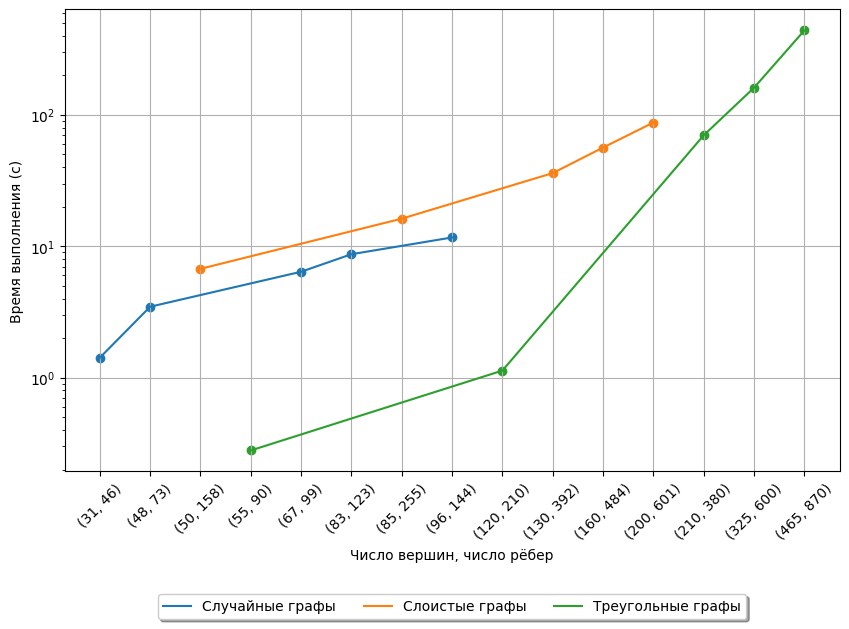

In [125]:
graphs = [
    # 'testing_graphs/16_envelope_mk_eq.time',
    # 'testing_graphs/16_envelope_mk_rand.time',
    # 'testing_graphs/64_envelope_mk_eq.time',
    # 'testing_graphs/64_envelope_mk_rand.time',
    'rand/dag26.time',
    'rand/dag15.time',
    'rand/dag16.time',
    'rand/dag13.time',
    'rand/dag0.time',
    'sausages/dagA15.time',
    'sausages/dagH28.time',
    'sausages/dagK43.time',
    'sausages/dagN19.time',
    'sausages/dagR49.time',
    'triangle/triadag10_5.time',
    'triangle/triadag15_4.time',
    'triangle/triadag20_5.time',
    'triangle/triadag25_0.time',
    'triangle/triadag30_7.time',
]

# paths = [
#     './results/greed/weighted/{}',
#     './results2/MK_greed_greed_weighted/weighted/{}',
#     './results2/MK_greed_greed_with_geq_cr/weighted/{}',
# ]

labels = []
y = []

pg_name = '5_4_3_2x5.txt'

cr_u = 0.35



fig, ax = plt.subplots(figsize=(10,6))

all_x = []
first_x = []

MK_greed_greed_weighted_y = []
MK_greed_greed_weighted_x = []
path = './results2/MK_greed_greed_weighted/weighted/{}'
for graph_name in graphs:
    graph_path = path.format(graph_name)
    with open(graph_path, 'r') as file:
        print(graph_path)
        for line in file.readlines():
            # triadag10_5.txt 5_4_3_2x5.txt 0.35 55 1716289529.4229527 1.0220365524291992
            _, pg, cr_lim, n, start_time, time = line.split()
            # cr = float(cr)
            # max_iter = int(max_iter)
            n = int(n)
            cr_lim = float(cr_lim)
            time = float(time)

            if pg_name == pg and cr_u == cr_lim:
                graph_path = f'./data/{graph_name}'.replace('triangle', 'triangle/graphs').replace('.time', '.txt')
                g = input_networkx_graph_from_file(graph_path)
                
                labels.append((n, len(g.edges)))

                MK_greed_greed_weighted_x.append(n)
                MK_greed_greed_weighted_y.append(time)
                break

# fig, ax = plt.subplots()

print(MK_greed_greed_weighted_y)

labels.sort(key=lambda _: _[1])
labels.sort(key=lambda _: _[0])

# labels = np.array(labels)

x = np.arange(len(labels))  # the label locations
labels = np.array(labels)
print(labels[:, 0])
print('---')
print(labels)
print(MK_greed_greed_weighted_y[:5])
ax.plot(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[:5])], MK_greed_greed_weighted_y[:5], label='Случайные графы')
ax.scatter(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[:5])], MK_greed_greed_weighted_y[:5])

ax.plot(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[5:10])], MK_greed_greed_weighted_y[5:10], label='Слоистые графы')
ax.scatter(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[5:10])], MK_greed_greed_weighted_y[5:10])

ax.plot(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[10:15])], MK_greed_greed_weighted_y[10:15], label='Треугольные графы')
ax.scatter(x[np.isin(labels[:, 0], MK_greed_greed_weighted_x[10:15])], MK_greed_greed_weighted_y[10:15])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Время выполнения (с)')
# ax.set_title(f'{graph_name.replace("sausages", "layered").split("/")[0]}, procs {pg_name.strip(".txt")}, CR_U {cr_u}')
ax.set_xlabel('Число вершин, число рёбер')
plt.xticks(x, map(tuple, labels), rotation=45)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=5)   
ax.grid(axis='both')
# ax.set_ylim(-20, 510)
# ax.set_yscale('log')
plt.show()

In [5]:
greed_results_dir: str = './results/greed/weighted/gen_data'
mk_results_dir: str = './results2/MK_greed_greed_weighted/weighted/gen_data'
mk_plus_results_dir: str = './results2/MK_greed_greed_with_geq_cr/weighted/gen_data'
simple_results_dir: str = './results2/simple_part/weighted/gen_data'

graph_data: dict[str, int] = dict()

greed_data: defaultdict[str, dict[float, tuple[float | None, float]]] = defaultdict(dict)
mk_data: defaultdict[str, dict[float, tuple[float | None, float]]] = defaultdict(dict)
mk_plus_data: defaultdict[str, dict[float, tuple[float | None, float]]] = defaultdict(dict)
simple_data: defaultdict[str, dict[float, tuple[float | None, float]]] = defaultdict(dict)

dir_n_data = (
    (greed_results_dir, greed_data),
    (mk_results_dir, mk_data),
    (mk_plus_results_dir, mk_plus_data),
    (simple_results_dir, simple_data)
)
for i, (dir, data) in enumerate(dir_n_data):
    print(i)
    for graph in listdir(dir):
        if 'time' in graph:
            continue
        try:
            if not graph.endswith('.graph'):
                raise NameError()
            proc_prefix, L, min_l, max_l, N, cr_gen, shuffle = graph.removesuffix('.graph').rsplit('_', maxsplit=6)
            L, min_l, max_l, N, cr_gen = int(L), int(min_l), int(max_l), float(N), float(cr_gen)
            if shuffle not in ['True', 'False']:
                raise NameError()
            shuffle = True if shuffle == 'True' else False
        except Exception as e:
            print(f'Что-то не то {e}, {join(dir, graph)}')
            continue
        graph_label = dir.split('/')[-1] + '/' + graph
        if i == 0:
            graph_data[graph_label] = L
        with open(join(dir, graph), 'r') as f:
            for line in f.readlines():
                try:
                    g, pg, cr_fact, cr_max, f_val, partition = line.split(maxsplit=5)
                    pg = pg.removesuffix('.txt').split('x')
                    pg_prefix = (pg[0] + '_') * int(pg[1])
                    cr_fact, cr_max, f_val = float(cr_fact) if cr_fact != 'None' else None, float(cr_max), float(f_val)
                    if '[' not in partition and cr_fact is not None:
                        print('[' not in partition, cr_fact is not None, join(dir, graph))
                        continue
                    partition = ast.literal_eval(partition)
                    if g != graph:
                        raise NameError(f'имя файла {g} != строчке в файле {graph}')
                    L, min_l, max_l, N, cr_gen, shuffle = graph.removeprefix(pg_prefix).removesuffix('.graph').split('_')
                    L, min_l, max_l, N, cr_gen = int(L), int(min_l), int(max_l), float(N), float(cr_gen)
                    if shuffle not in ['True', 'False']:
                        raise NameError()
                except Exception as e:
                    print('->', e, join(greed_results_dir, graph))
                    continue
                data[graph_label][cr_max] = (cr_fact, f_val)

0


FileNotFoundError: [Errno 2] No such file or directory: './results/greed/weighted/gen_data'

gen_data/3_2_3_2_3_2_3_2_3_2_1000_10_100_2.0_0.6_False.graph


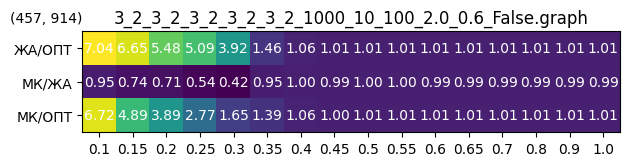

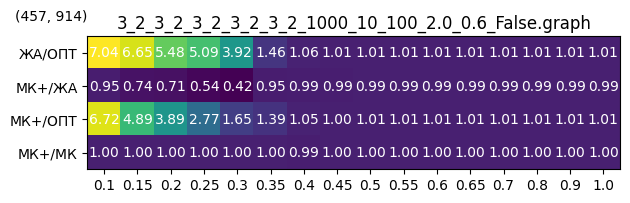

gen_data/4_1_4_1_4_1_4000_10_100_4.0_0.4_True.graph


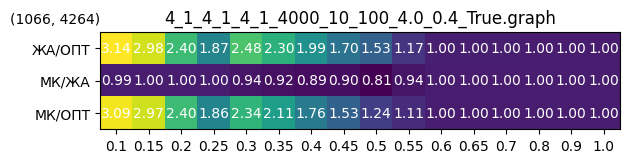

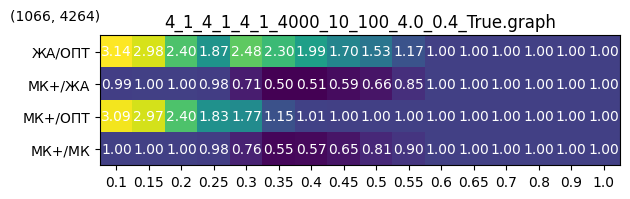

gen_data/4_1_4_1_4_1_1000_10_100_2.0_0.4_False.graph


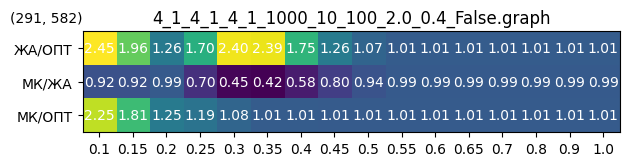

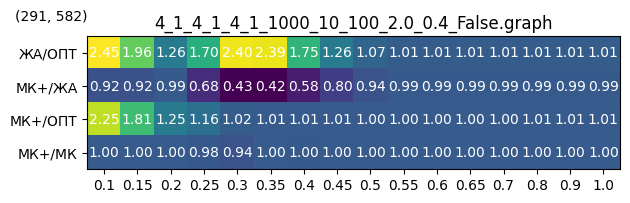

gen_data/4_1_4_1_4_1_1000_10_100_3.0_0.2_True.graph


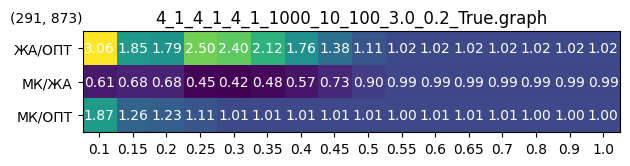

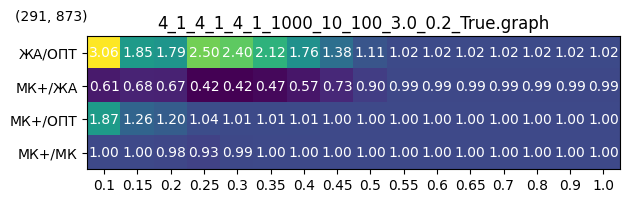

gen_data/3_2_4000_10_100_4.0_0.2_False.graph


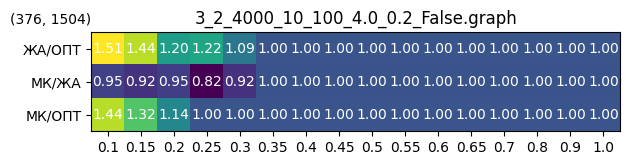

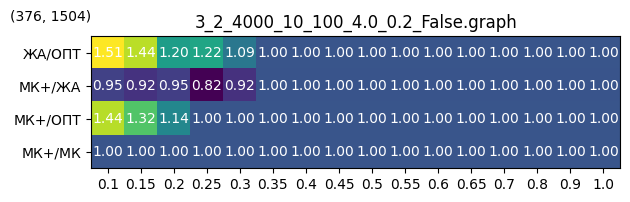

gen_data/4_1_1000_10_100_4.0_0.6_False.graph


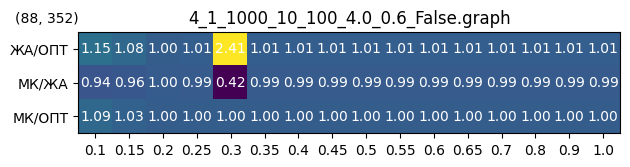

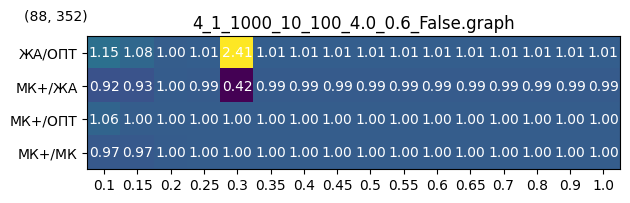

gen_data/3_2_3_2_3_2_1000_10_100_3.0_0.6_False.graph


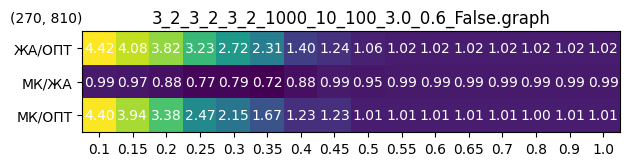

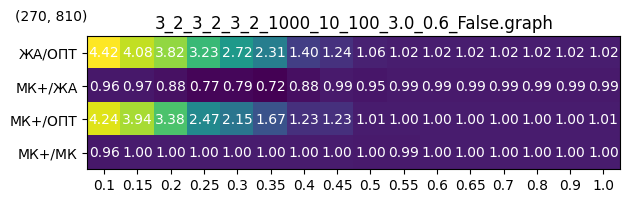

gen_data/3_2_3_2_3_2_1000_10_100_4.0_0.6_False.graph


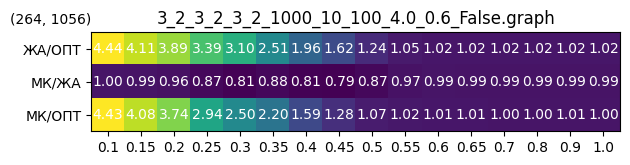

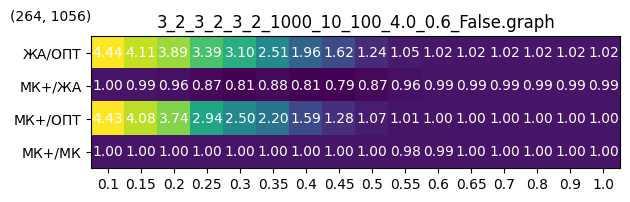

gen_data/3_2_3_2_3_2_3_2_3_2_1000_10_100_4.0_0.6_False.graph


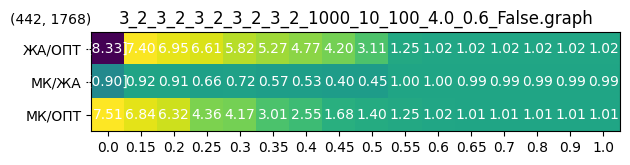

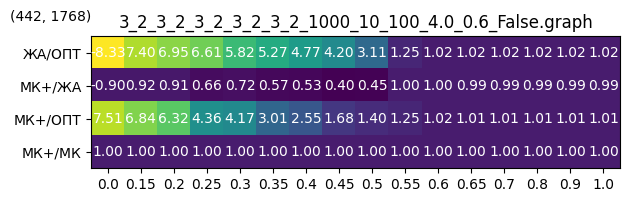

gen_data/3_2_3_2_3_2_3_2_3_2_4000_10_100_2.0_0.2_False.graph


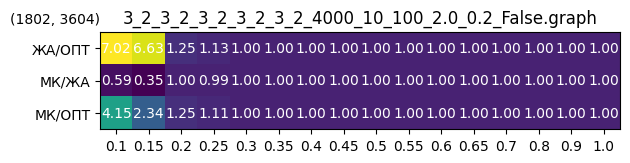

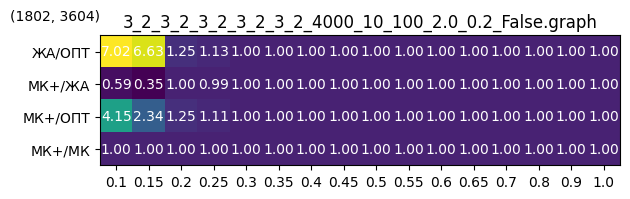

gen_data/3_2_3_2_3_2_4000_10_100_2.0_0.2_True.graph


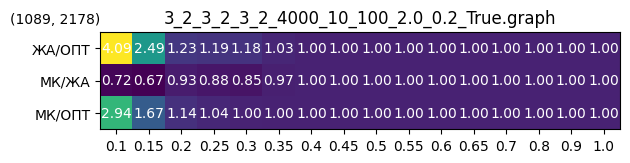

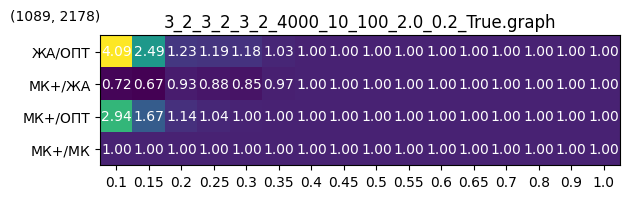

gen_data/3_2_3_2_3_2_3_2_3_2_4000_10_100_4.0_0.6_False.graph


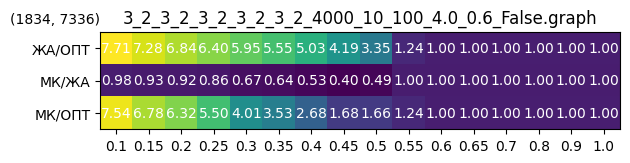

operands could not be broadcast together with shapes (14,) (16,)  14 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_4000_10_100_4.0_0.6_False.graph ./results/greed/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_4000_10_100_4.0_0.6_False.graph
gen_data/4_1_4000_10_100_3.0_0.2_False.graph


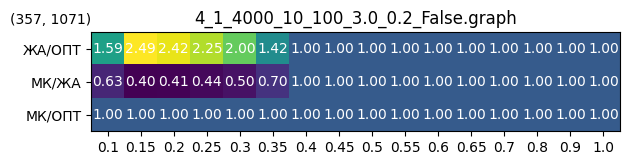

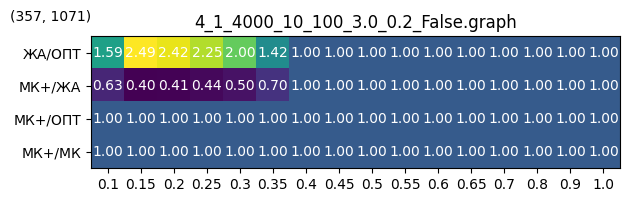

gen_data/4_1_2000_10_100_4.0_0.2_True.graph


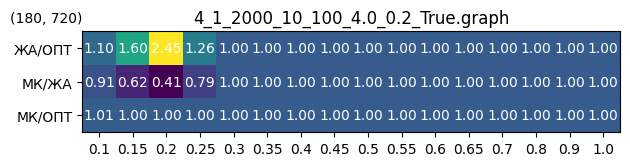

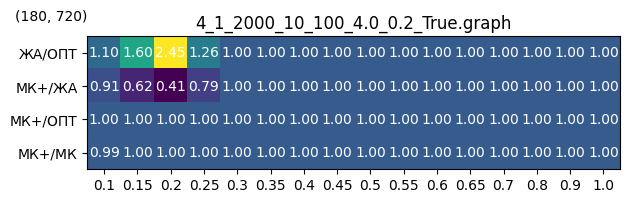

gen_data/4_1_1000_10_100_3.0_0.4_False.graph


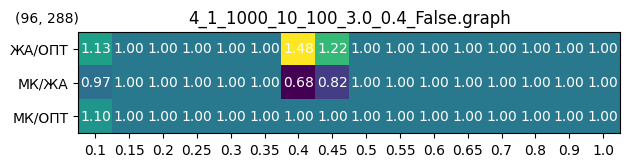

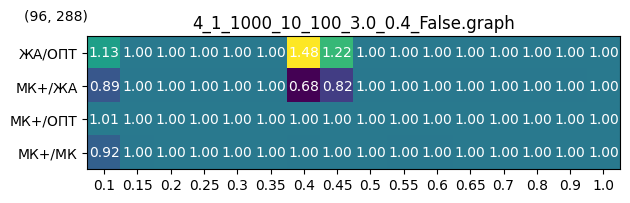

gen_data/3_2_3_2_3_2_2000_10_100_3.0_0.6_True.graph


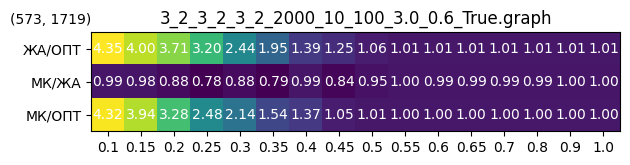

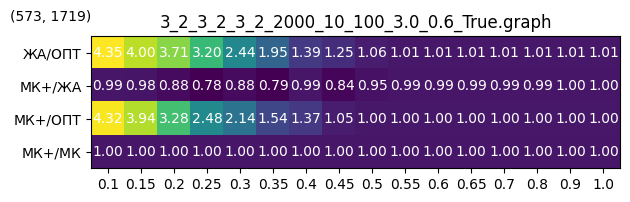

gen_data/4_1_1000_10_100_3.0_0.4_True.graph


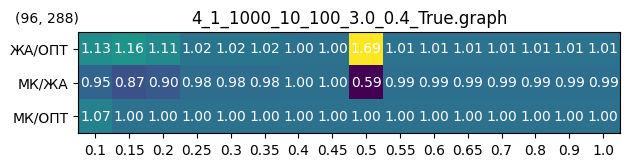

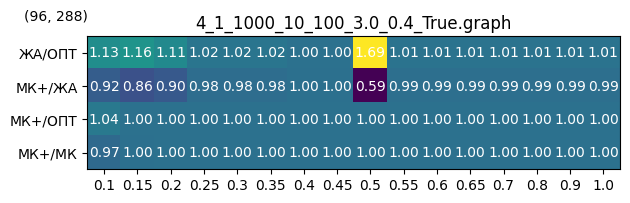

gen_data/4_1_4000_10_100_4.0_0.6_True.graph


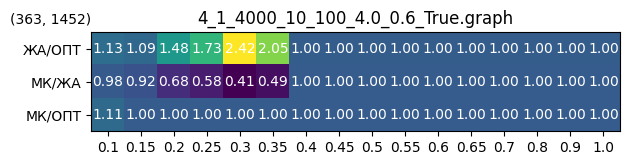

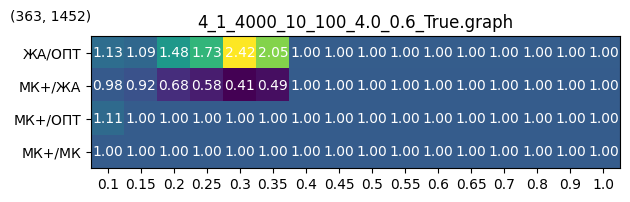

gen_data/3_2_3_2_3_2_3_2_3_2_2000_10_100_3.0_0.4_True.graph


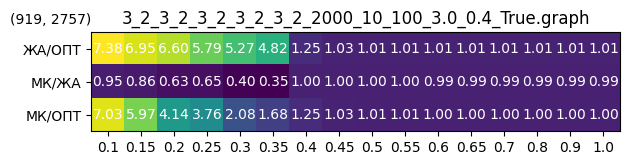

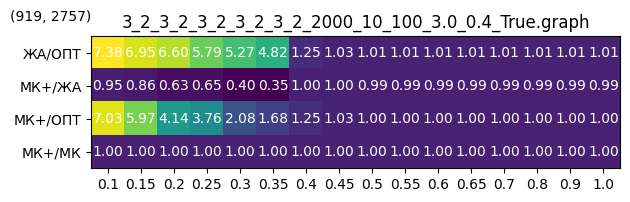

gen_data/4_1_4000_10_100_3.0_0.6_True.graph


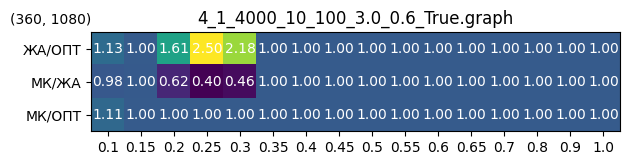

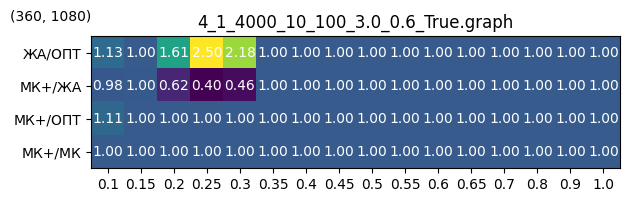

gen_data/3_2_1000_10_100_3.0_0.2_False.graph


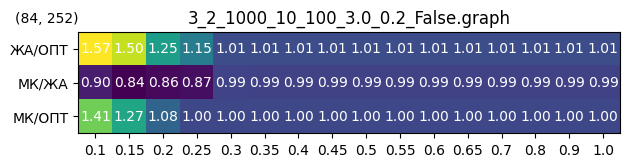

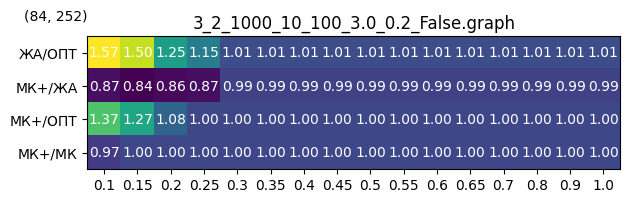

gen_data/4_1_4000_10_100_2.0_0.6_False.graph


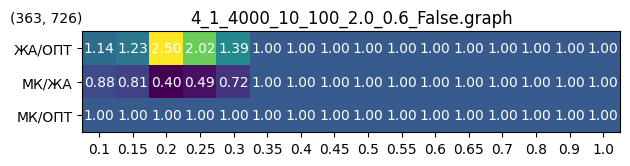

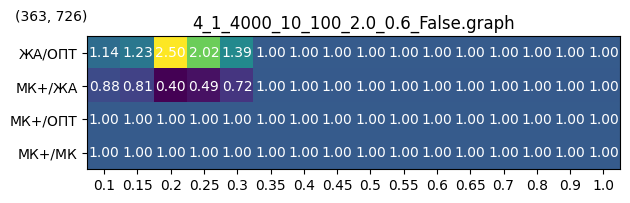

gen_data/5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_False.graph


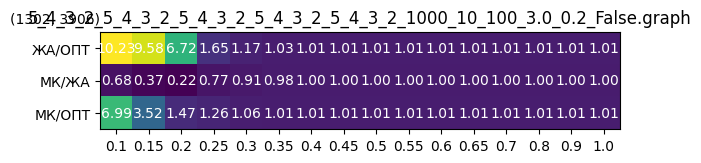

operands could not be broadcast together with shapes (7,) (16,)  7 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_False.graph ./results/greed/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_False.graph
gen_data/4_1_4_1_4_1_4_1_4_1_1000_10_100_4.0_0.6_False.graph


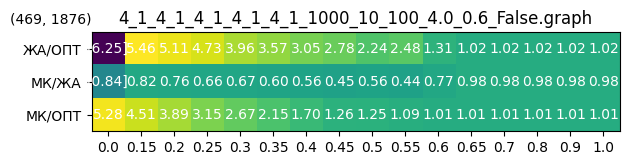

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/4_1_4_1_4_1_4_1_4_1_1000_10_100_4.0_0.6_False.graph ./results/greed/weighted/gen_data/4_1_4_1_4_1_4_1_4_1_1000_10_100_4.0_0.6_False.graph
gen_data/4_1_4_1_4_1_4_1_4_1_2000_10_100_4.0_0.4_False.graph


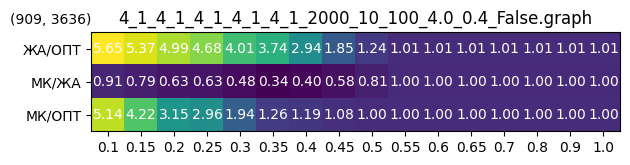

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/4_1_4_1_4_1_4_1_4_1_2000_10_100_4.0_0.4_False.graph ./results/greed/weighted/gen_data/4_1_4_1_4_1_4_1_4_1_2000_10_100_4.0_0.4_False.graph
gen_data/4_1_4_1_4_1_4000_10_100_4.0_0.2_False.graph


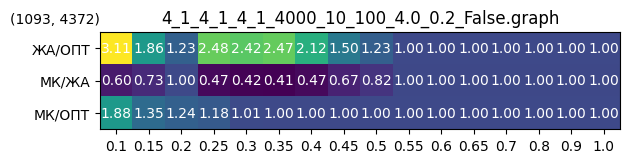

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/4_1_4_1_4_1_4000_10_100_4.0_0.2_False.graph ./results/greed/weighted/gen_data/4_1_4_1_4_1_4000_10_100_4.0_0.2_False.graph
gen_data/3_2_3_2_3_2_3_2_3_2_1000_10_100_3.0_0.2_False.graph


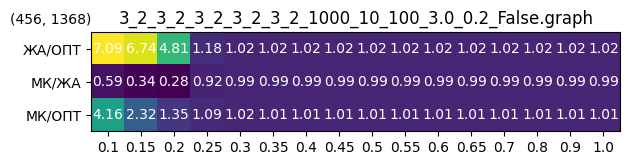

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_1000_10_100_3.0_0.2_False.graph ./results/greed/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_1000_10_100_3.0_0.2_False.graph
gen_data/5_4_3_2_1000_10_100_2.0_0.2_False.graph


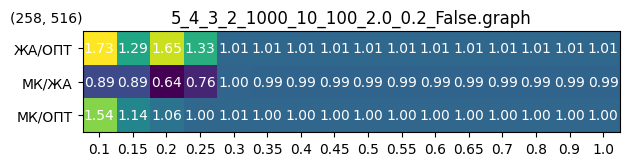

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_1000_10_100_2.0_0.2_False.graph ./results/greed/weighted/gen_data/5_4_3_2_1000_10_100_2.0_0.2_False.graph
gen_data/4_1_4_1_4_1_4000_10_100_4.0_0.4_False.graph


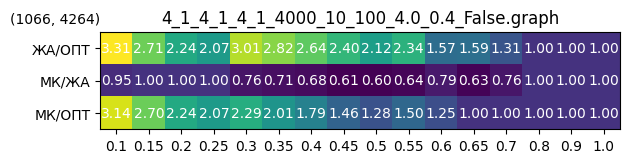

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/4_1_4_1_4_1_4000_10_100_4.0_0.4_False.graph ./results/greed/weighted/gen_data/4_1_4_1_4_1_4000_10_100_4.0_0.4_False.graph
gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_False.graph


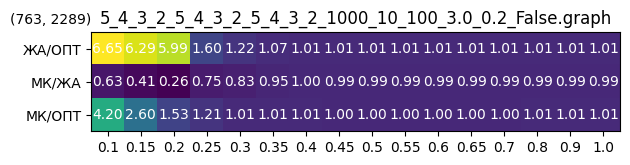

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_False.graph ./results/greed/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_False.graph
gen_data/3_2_3_2_3_2_3_2_3_2_4000_10_100_3.0_0.2_True.graph


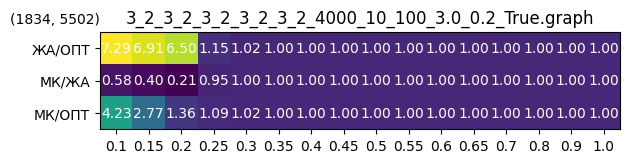

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_4000_10_100_3.0_0.2_True.graph ./results/greed/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_4000_10_100_3.0_0.2_True.graph
gen_data/5_4_3_2_2000_10_100_4.0_0.4_False.graph


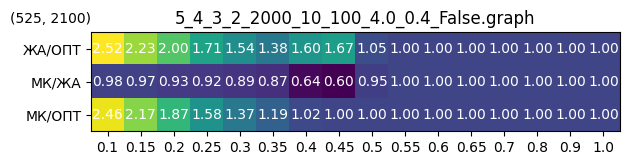

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_2000_10_100_4.0_0.4_False.graph ./results/greed/weighted/gen_data/5_4_3_2_2000_10_100_4.0_0.4_False.graph
gen_data/3_2_3_2_3_2_3_2_3_2_2000_10_100_3.0_0.6_True.graph


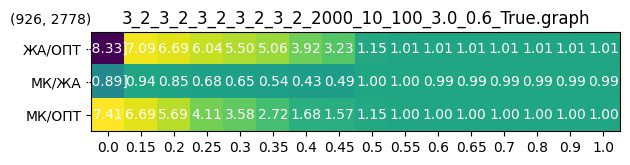

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_2000_10_100_3.0_0.6_True.graph ./results/greed/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_2000_10_100_3.0_0.6_True.graph
gen_data/4_1_1000_10_100_4.0_0.2_False.graph


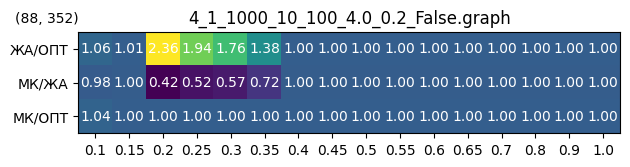

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/4_1_1000_10_100_4.0_0.2_False.graph ./results/greed/weighted/gen_data/4_1_1000_10_100_4.0_0.2_False.graph
gen_data/5_4_3_2_5_4_3_2_5_4_3_2_4000_10_100_4.0_0.2_False.graph


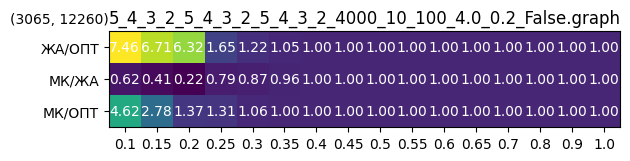

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_4000_10_100_4.0_0.2_False.graph ./results/greed/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_4000_10_100_4.0_0.2_False.graph
gen_data/5_4_3_2_1000_10_100_3.0_0.2_True.graph


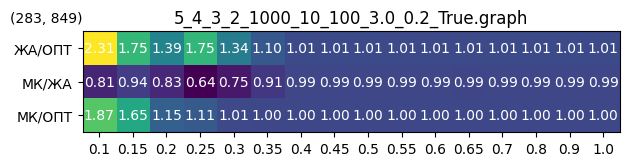

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_1000_10_100_3.0_0.2_True.graph ./results/greed/weighted/gen_data/5_4_3_2_1000_10_100_3.0_0.2_True.graph
gen_data/5_4_3_2_4000_10_100_3.0_0.4_True.graph


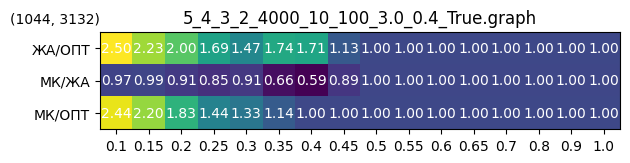

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_4000_10_100_3.0_0.4_True.graph ./results/greed/weighted/gen_data/5_4_3_2_4000_10_100_3.0_0.4_True.graph
gen_data/5_4_3_2_5_4_3_2_5_4_3_2_2000_10_100_2.0_0.6_True.graph


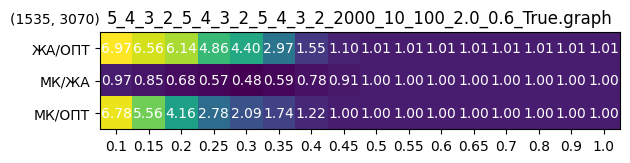

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_2000_10_100_2.0_0.6_True.graph ./results/greed/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_2000_10_100_2.0_0.6_True.graph
gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_4.0_0.4_False.graph


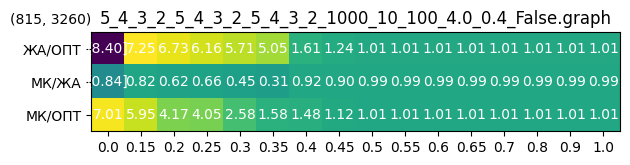

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_4.0_0.4_False.graph ./results/greed/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_4.0_0.4_False.graph
gen_data/3_2_3_2_3_2_2000_10_100_4.0_0.6_True.graph


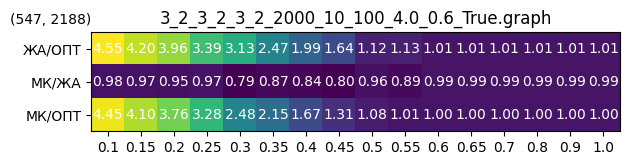

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/3_2_3_2_3_2_2000_10_100_4.0_0.6_True.graph ./results/greed/weighted/gen_data/3_2_3_2_3_2_2000_10_100_4.0_0.6_True.graph
gen_data/5_4_3_2_2000_10_100_3.0_0.2_False.graph


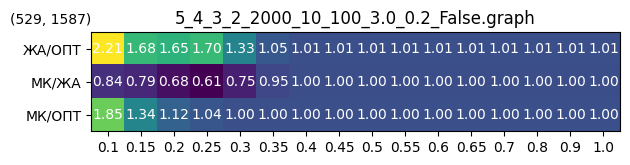

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_2000_10_100_3.0_0.2_False.graph ./results/greed/weighted/gen_data/5_4_3_2_2000_10_100_3.0_0.2_False.graph
gen_data/3_2_3_2_3_2_3_2_3_2_2000_10_100_2.0_0.4_False.graph


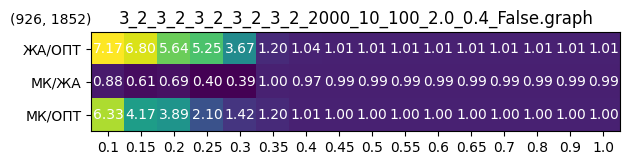

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_2000_10_100_2.0_0.4_False.graph ./results/greed/weighted/gen_data/3_2_3_2_3_2_3_2_3_2_2000_10_100_2.0_0.4_False.graph
gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_True.graph


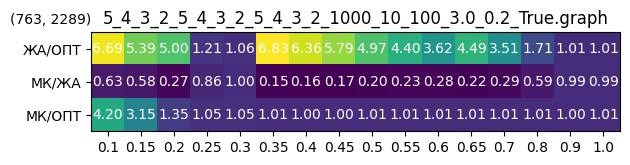

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_True.graph ./results/greed/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_1000_10_100_3.0_0.2_True.graph
gen_data/5_4_3_2_2000_10_100_3.0_0.4_False.graph


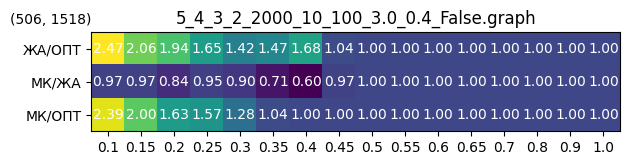

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/5_4_3_2_2000_10_100_3.0_0.4_False.graph ./results/greed/weighted/gen_data/5_4_3_2_2000_10_100_3.0_0.4_False.graph
gen_data/4_1_4_1_4_1_4000_10_100_3.0_0.6_True.graph


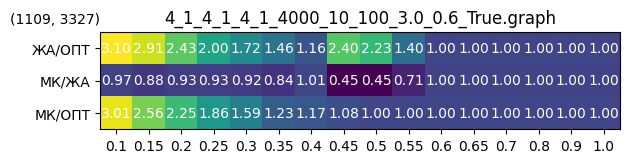

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/4_1_4_1_4_1_4000_10_100_3.0_0.6_True.graph ./results/greed/weighted/gen_data/4_1_4_1_4_1_4000_10_100_3.0_0.6_True.graph
gen_data/3_2_3_2_3_2_2000_10_100_4.0_0.2_False.graph


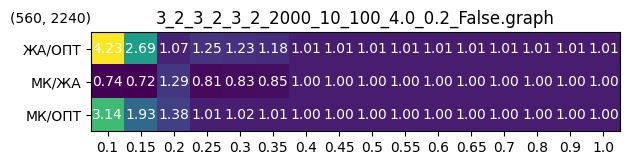

operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_with_geq_cr/weighted/gen_data/3_2_3_2_3_2_2000_10_100_4.0_0.2_False.graph ./results/greed/weighted/gen_data/3_2_3_2_3_2_2000_10_100_4.0_0.2_False.graph
gen_data/5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_4000_10_100_3.0_0.6_False.graph
operands could not be broadcast together with shapes (5,) (16,)  5 16 ./results2/MK_greed_greed_weighted/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_4000_10_100_3.0_0.6_False.graph ./results/greed/weighted/gen_data/5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_5_4_3_2_4000_10_100_3.0_0.6_False.graph
gen_data/3_2_3_2_3_2_2000_10_100_2.0_0.4_False.graph
operands could not be broadcast together with shapes (0,) (16,)  0 16 ./results2/MK_greed_greed_weighted/weighted/gen_data/3_2_3_2_3_2_2000_10_100_2.0_0.4_False.graph ./results/greed/weighted/gen_data/3_2_3_2_3_2_2000_10_100_2.0_0.4_False.graph
gen_data/4_1_4_1_4_1_2000_10_100_3.0_0.2_True.graph
operands could not b

In [ ]:
cnt1, cnt2, cnt3 = 0, 0, 0
draw_crp = False
draw_crp = True
y_labels = ['ЖА/ОПТ', 'МК/ЖА', 'МК/ОПТ']
for graph in greed_data:
    print(graph)
    cnt1 += 1
    heatmap = []
    heat_line = []
    for cr_max, (cr_fact, f_val) in greed_data[graph].items():
        # if cr_fact is not None:
        heat_line.append((cr_max, f_val))
        # else:
            # heat_line.append(simple_data[graph][cr_max])
    
    cr_list = list(sorted(map(lambda x: x[0], heat_line)))
    heat_line = list(map(lambda x: x[1], sorted(heat_line, key=lambda x: x[0])))
    heat_line = np.array(heat_line)
    
    greed_vals = np.array(heat_line, dtype=np.float64)
    heatmap.append(greed_vals / graph_data[graph])
    
    heat_line = []
    for cr_max, (cr_fact, f_val) in mk_data[graph].items():
        heat_line.append((cr_max, f_val))
    heat_line = list(map(lambda x: x[1], sorted(heat_line, key=lambda x: x[0])))
    heat_line = np.array(heat_line)
    mk_vals = heat_line

    try:
        heatmap.append(np.divide(np.array(mk_vals), np.array(greed_vals)))
    except Exception as e:
        print(e, len(mk_vals), len(greed_vals), f'{mk_results_dir}/{graph.split('/')[-1]}', f'{greed_results_dir}/{graph.split('/')[-1]}')
        continue
    heatmap.append(np.array(mk_vals) / graph_data[graph])
    heatmap = np.array(heatmap) 

    fig, ax = plt.subplots()
    im = ax.imshow(heatmap)
    
    ax.set_xticks(np.arange(len(cr_list)), labels=cr_list)
    ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)
    
    for i in range(len(y_labels)):
        for j in range(len(cr_list)):
            val = f'{heatmap[i, j]:.2f}' if heatmap[i, j] < 100 else '-'
            text = ax.text(j, i, f'{val}', ha="center", va="center", color="w")
    
    g = input_graph(f'./data/{graph}')
    ax.text(0, 1.2, f'({g.number_of_nodes()}, {g.number_of_edges()})',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
    
    ax.set_title(graph.split('/')[-1])
    fig.tight_layout()
    
    plt.show()
    cnt2 += 1
    if draw_crp:
        heatmap = [greed_vals / graph_data[graph]]
        
        heat_line = []
        for cr_max, (cr_fact, f_val) in mk_plus_data[graph].items():
            heat_line.append((cr_max, f_val))
        heat_line = list(map(lambda x: x[1], sorted(heat_line, key=lambda x: x[0])))
        heat_line = np.array(heat_line)
        mk_plus_vals = heat_line

        try:
            heatmap.append(np.divide(np.array(mk_plus_vals), np.array(greed_vals)))
            heatmap.append(np.array(mk_plus_vals) / graph_data[graph])
            heatmap.append(np.array(mk_plus_vals) / mk_vals)
        except Exception as e:
            print(e, len(mk_plus_vals), len(greed_vals), f'{mk_plus_results_dir}/{graph.split('/')[-1]}', f'{greed_results_dir}/{graph.split('/')[-1]}')
            continue
        heatmap = np.array(heatmap) 

        fig, ax = plt.subplots()
        im = ax.imshow(heatmap)
        
        ax.set_xticks(np.arange(len(cr_list)), labels=cr_list)
        ax.set_yticks(np.arange(len(y_labels) + 1), labels=list(map(lambda x: x.replace('МК', 'МК+'), y_labels)) + ['МК+/МК'])
        
        for i in range(len(y_labels) + 1):
            for j in range(len(cr_list)):
                text = ax.text(j, i, f'{heatmap[i, j]:.2f}', ha="center", va="center", color="w")
        
        ax.text(0, 1.2, f'({g.number_of_nodes()}, {g.number_of_edges()})',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)
        
        ax.set_title(graph.split('/')[-1])
        fig.tight_layout()
        
        plt.show()
    cnt3 += 1
print(cnt1, cnt2, cnt3)

./data/gen_data/4_1_4_1_4000_10_100_2.0_0.1_True.graph
[4, 1, 4, 1]
4931.0


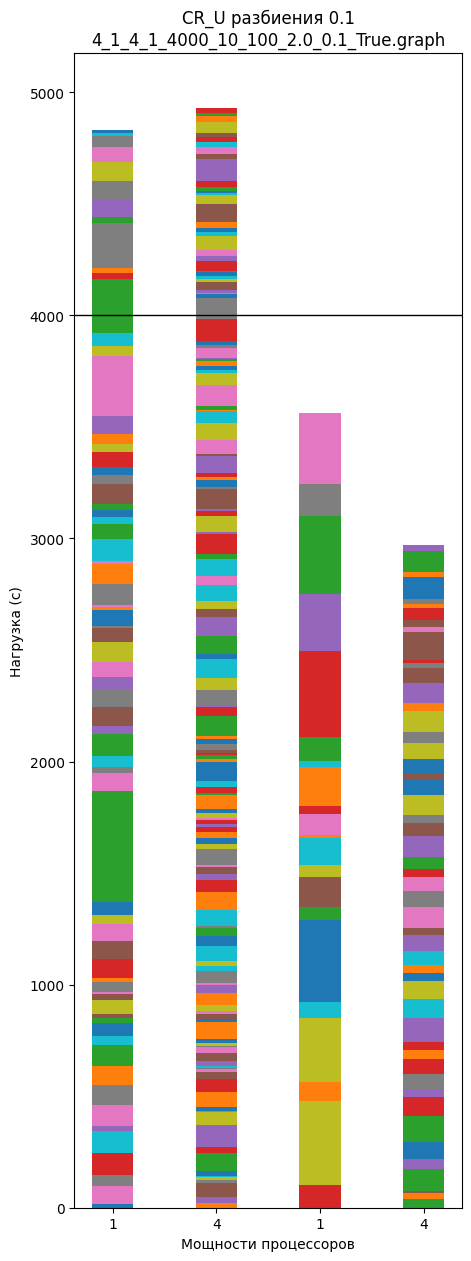

In [6]:
# graph_name = '4_1_4_1_4000_10_100_2.0_0.1_True.graph'
graph_name = '4_1_4_1_4000_10_100_2.0_0.1_True.graph'
graph_path = f'./data/gen_data/{graph_name}'
print(graph_path)
partition_path = f'./results/greed/weighted/gen_data/{graph_name}'
cr = ' 0.1 '
pg_name = ' 1_4x2.txt '

graph, p, graph_params = input_generated_graph_and_processors_from_file(graph_path)
with open(partition_path, 'r') as f:
    for line in f.readlines():
        if pg_name in line and cr in line and '[' in line:
            _, _, _, cr_fact, _, f_val, partiton = line.split(maxsplit=6)
            partiton = eval(partiton)
            # break


# pg_name = pg_name.strip().strip('.txt').split('x')
# p = sorted(map(int, pg_name[0].split('_'))) * int(pg_name[1]) 
bottom = [0] * len(p)
 
fig = plt.figure(figsize = (5, 15))
# ax1 = fig.add_subplot()

# creating the bar plot

# print(bottom)
# for i in range(len(p)):
for job_num, proc_num in enumerate(partiton):
    
    bar = [0] * len(p)
    bar[proc_num] += graph.nodes[job_num]['weight'] / p[proc_num]
    plt.bar(range(len(p)), bar, bottom=bottom, width=0.4)
    bottom[proc_num] += graph.nodes[job_num]['weight'] / p[proc_num]

plt.axhline(y=graph_params['L'], linewidth=1, color='k')
# plt.axhline(y=f_val, linewidth=1, color='r')
print(f_val)

plt.xlabel("Мощности процессоров")
plt.ylabel("Нагрузка (с)")
plt.xticks(range(len(p)), p)
# secax = fig.secondary_xaxis('top', functions=(deg2rad, rad2deg))
# ax2.set_xlim(fig.get_xlim())
# ax2 = ax1.twiny()
plt.title(f'CR_U разбиения {cr.strip()}\n' + graph_name)
plt.show()

In [ ]:
graph_type: str = 'rand_first100'

path_greed: str = f'./results/greed/weighted/{graph_type}/{{}}'
path_greed_mk: str = f'./results2/MK_greed_greed_weighted/weighted/{graph_type}/{{}}'
path_mk_geq_cr: str = f'./results2/MK_greed_greed_with_geq_cr/weighted/{graph_type}/{{}}'
path_simple: str = f'./results2/simple_part/weighted/{graph_type}/{{}}'

print(paths[1].removesuffix('/{}'))
print(sorted(listdir(paths[1].removesuffix('/{}'))))

['dag63.txt', 'dag41.time', 'dag1.txt', 'dag78.txt', 'dag67.txt', 'dag20.txt', 'dag0.txt', 'dag71.time', 'dag15.time', 'dag8.time', 'dag22.txt', 'dag95.time', 'dag99.time', 'dag98.txt', 'dag74.time', 'dag28.txt', 'dag8.txt', 'dag9.txt', 'dag4.time', 'dag90.time', 'dag46.time', 'dag17.time', 'dag94.time', 'dag54.txt', 'dag47.txt', 'dag24.txt', 'dag7.time', 'dag44.time', 'dag85.time', 'dag4.txt', 'dag30.time', 'dag58.txt', 'dag87.txt', 'dag68.time', 'dag84.time', 'dag11.txt', 'dag25.time', 'dag6.txt', 'dag50.txt', 'dag23.time', 'dag0.time', 'dag55.txt', 'dag84.txt', 'dag11.time', 'dag68.txt', 'dag48.time', 'dag45.time', 'dag37.txt', 'dag77.txt', 'dag70.txt', 'dag18.time', 'dag65.time', 'dag88.time', 'dag77.time', 'dag22.time', 'dag47.time', 'dag37.time', 'dag63.time', 'dag14.txt', 'dag56.time', 'dag30.txt', 'dag78.time', 'dag89.time', 'dag32.time', 'dag43.time', 'dag53.txt', 'dag82.time', 'dag62.time', 'dag7.txt', 'dag26.time', 'dag51.txt', 'dag83.txt', 'dag58.time', 'dag6.time', 'dag82.

In [ ]:
paths: list[str] = [
    path_greed,
    path_greed_mk,
    # path_mk_geq_cr,
    path_simple
]

files = list(filter(lambda x: x.endswith('.txt'), listdir(paths[1].removesuffix('/{}'))))
# print(sorted(files))

datas = [dict() for _ in range(len(paths))]  # <-----------------------------------------------------------

cr_set = set()
for graph_name in files:
    for path, data in zip(map(lambda x: x.format(graph_name), paths), datas):
        data[graph_name] = defaultdict(dict)
        with open(path, 'r') as file:
            for line in file.readlines():
                line = line.strip()
                try:
                    g_name, pg_name, cr, cr_lim, f_val, *_ = line.split()
                    if g_name != graph_name.split('/')[-1]:
                        continue
                    cr, cr_lim, f_val = float(cr) if cr != 'None' else None, float(cr_lim), float(f_val)
                except Exception as e:
                    print(cr, cr_lim, f_val)
                    print(e)
                    print(line)
                    print(path)
                    continue

                pg_name = pg_name.removesuffix('.txt')
                pg_name = '_'.join(list(map(str, sorted(list(map(int, pg_name.split('x')[0].split('_'))), reverse=True)))) + 'x' + pg_name.split('x')[1]
                
                cr_set.add(cr_lim)
                data[graph_name][pg_name][cr_lim] = float(f_val)

(
    greed_data, 
    # data_mk_geq_cr, 
    greed_mk_data, 
    simple_data 
) = datas

['dag0.txt', 'dag1.txt', 'dag10.txt', 'dag11.txt', 'dag12.txt', 'dag13.txt', 'dag14.txt', 'dag15.txt', 'dag17.txt', 'dag18.txt', 'dag19.txt', 'dag2.txt', 'dag20.txt', 'dag21.txt', 'dag22.txt', 'dag23.txt', 'dag24.txt', 'dag25.txt', 'dag26.txt', 'dag27.txt', 'dag28.txt', 'dag29.txt', 'dag30.txt', 'dag32.txt', 'dag33.txt', 'dag34.txt', 'dag35.txt', 'dag37.txt', 'dag38.txt', 'dag39.txt', 'dag4.txt', 'dag41.txt', 'dag42.txt', 'dag43.txt', 'dag44.txt', 'dag45.txt', 'dag46.txt', 'dag47.txt', 'dag48.txt', 'dag49.txt', 'dag5.txt', 'dag50.txt', 'dag51.txt', 'dag53.txt', 'dag54.txt', 'dag55.txt', 'dag56.txt', 'dag57.txt', 'dag58.txt', 'dag59.txt', 'dag6.txt', 'dag60.txt', 'dag61.txt', 'dag62.txt', 'dag63.txt', 'dag64.txt', 'dag65.txt', 'dag66.txt', 'dag67.txt', 'dag68.txt', 'dag69.txt', 'dag7.txt', 'dag70.txt', 'dag71.txt', 'dag72.txt', 'dag73.txt', 'dag74.txt', 'dag76.txt', 'dag77.txt', 'dag78.txt', 'dag79.txt', 'dag8.txt', 'dag80.txt', 'dag81.txt', 'dag82.txt', 'dag83.txt', 'dag84.txt', 'dag85

In [19]:
# print(greed_mk_data)
print(sorted(greed_mk_data.keys()))
print(len(greed_mk_data.keys()))
# print(greed_mk_data['dagK43.txt'].keys())
# print(greed_mk_data['dagK43.txt']['5_4_3_2x1'])

['dag0.txt', 'dag1.txt', 'dag10.txt', 'dag11.txt', 'dag12.txt', 'dag13.txt', 'dag14.txt', 'dag15.txt', 'dag17.txt', 'dag18.txt', 'dag19.txt', 'dag2.txt', 'dag20.txt', 'dag21.txt', 'dag22.txt', 'dag23.txt', 'dag24.txt', 'dag25.txt', 'dag26.txt', 'dag27.txt', 'dag28.txt', 'dag29.txt', 'dag30.txt', 'dag32.txt', 'dag33.txt', 'dag34.txt', 'dag35.txt', 'dag37.txt', 'dag38.txt', 'dag39.txt', 'dag4.txt', 'dag41.txt', 'dag42.txt', 'dag43.txt', 'dag44.txt', 'dag45.txt', 'dag46.txt', 'dag47.txt', 'dag48.txt', 'dag49.txt', 'dag5.txt', 'dag50.txt', 'dag51.txt', 'dag53.txt', 'dag54.txt', 'dag55.txt', 'dag56.txt', 'dag57.txt', 'dag58.txt', 'dag59.txt', 'dag6.txt', 'dag60.txt', 'dag61.txt', 'dag62.txt', 'dag63.txt', 'dag64.txt', 'dag65.txt', 'dag66.txt', 'dag67.txt', 'dag68.txt', 'dag69.txt', 'dag7.txt', 'dag70.txt', 'dag71.txt', 'dag72.txt', 'dag73.txt', 'dag74.txt', 'dag76.txt', 'dag77.txt', 'dag78.txt', 'dag79.txt', 'dag8.txt', 'dag80.txt', 'dag81.txt', 'dag82.txt', 'dag83.txt', 'dag84.txt', 'dag85

In [17]:
graph_paths: list[tuple[str, str]] = [
    # ('./data/gen_data', 'gen_data'),
    # ('./data/rand', 'rand'),
    # ('./data/sausages/', 'sausages'),
    # ('./data/triangle/graphs/', 'triangle'),

    ('./data/rand_first100/', 'rand_first100'),
]

proc_classes: list[str] = ['3_2', '5_4_3_2', '4_1']

for graphs_path, graph_type in graph_paths:
    graph_names = greed_mk_data.keys()
    for proc_class in proc_classes:
        fractions: list = []
        for graph_name in graph_names:
            for proc in filter(lambda x: x.startswith(proc_class), greed_mk_data[graph_name].keys()):
                for cr in filter(lambda x: x <= 0.6, greed_mk_data[graph_name][proc].keys()):
                    val = greed_mk_data[graph_name][proc][cr] / greed_data[graph_name][proc][cr]
                    if val <= 0.001:
                        greed_mk_data[graph_name][proc][cr] / simple_data[graph_name][proc][cr]
                    fractions.append((val, graph_name, proc, cr))

        vals = [0 for _ in range(6)]        
        for i, *_ in fractions:
            if i < 0.2:
                ind = 0
            elif 0.2 <= i < 0.4:
                ind = 1
            elif 0.4 <= i < 0.6:
                ind = 2
            elif 0.6 <= i < 0.8:
                ind = 3
            elif 0.8 <= i <= 1:
                ind = 4
            else:
                ind = 5
                # print(i, _)
 
            vals[ind] += 1 

        y = np.array(vals)

        mylabels = ["<0.2", "[0.2; 0.4)", "[0.4, 0.6)", "[0.6, 0.8)", "[0.8; 1]", f"(1, {max(fractions, key=lambda x: x[0])[0]:.3f}]"]
        
        plt.pie(y, labels = mylabels, labeldistance=1.07, autopct='%1.1f%%', pctdistance=0.8)
        # plt.legend()
        plt.legend(bbox_to_anchor =(1.2, -0.10), loc='lower right')
        title = graph_type if graph_type != 'sausages' else 'layered'
        plt.title(f'{title} {proc_class}')
        Path(f'./pics_total/{title}').mkdir(parents=True, exist_ok=True)
        plt.savefig(f'./pics_total/{title}/{title}_{proc_class}.png')
        plt.close()

In [18]:
for graph_name in files:
    pg_names0 = list(greed_mk_data[graph_name].keys())
    pgs = list(set(pg.split('x')[0] for pg in pg_names0))
    print(list(pg_names0))
    for pg in pgs:
        print('pg is ', pg)
        pg_names = list(filter(lambda x: x.startswith(pg) , pg_names0))
        cr_list = sorted(list(greed_mk_data[graph_name][pg_names[0]].keys()))
        print('-', cr_list)
        
        pg_names = list(sorted(
            pg_names,
            key=lambda x: int(x.split('x')[1]),
            reverse=True,
        ))

        heats = [[] for _ in pg_names]
        simple = [[] for _ in pg_names]
        
        for i, pg_name in enumerate(pg_names):
            for cr in cr_list:
                heats[i].append(
                    greed_mk_data[graph_name][pg_name][cr] / greed_data[graph_name][pg_name][cr]
                )

                simple[i].append(
                    greed_mk_data[graph_name][pg_name][cr] / simple_data[graph_name][pg_name][cr]
                )
        
        heats = np.array(heats)
        simple = np.array(simple)
        
        fig, ax = plt.subplots(figsize=(len(cr_list)//2, len(pg_name)))
        im = ax.imshow(heats)
        print(heats)
        
        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(len(cr_list)), labels=cr_list)
        ax.set_yticks(np.arange(len(pg_names)), labels=pg_names)
        
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")
        
        # Loop over data dimensions and create text annotations.
        for i in range(len(pg_names)):
            for j in range(len(cr_list)):
                val = f'{heats[i, j]:.2f}' if heats[i, j] > 0.001 else f'[{simple[i, j]:.2f}]'
                text = ax.text(j, i, f'{val}',
                            ha="center", va="center", color="w")
        
        title = f'{graph_name}\n\n' + f'F(ПЖ_МК{"_CR+" if "geq_cr" in path_greed_mk else ""})/F(Greedy_Reg)'
        title = title.replace("sausages", "layered")
        ax.set_title(title)

        fig.tight_layout()
        # plt.show()
        Path(f'./pics/{graph_name.removesuffix(".txt")}').mkdir(parents=True, exist_ok=True)
        fig.savefig(f'./pics/{graph_name.removesuffix(".txt")}/{graph_name.removesuffix(".txt")}_{pg}.png')
        plt.close(fig)

['3_2x4', '5_4_3_2x2', '4_1x5', '3_2x3', '5_4_3_2x5', '4_1x1', '5_4_3_2x3', '4_1x4', '4_1x2', '3_2x2', '5_4_3_2x1', '5_4_3_2x4', '4_1x3', '3_2x1', '3_2x5']
pg is  5_4_3_2
- [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0]
[[3.29318400e-05 5.82375479e-01 4.87804878e-01 4.39130435e-01
  3.41232227e-01 3.00000000e-01 3.14814815e-01 3.55691057e-01
  4.41176471e-01 5.29411765e-01 8.00000000e-01 8.20512821e-01
  8.88888889e-01 9.69696970e-01 8.88888889e-01 9.69696970e-01]
 [3.27680000e-05 6.15384615e-01 5.21739130e-01 4.27312775e-01
  3.63636364e-01 3.18181818e-01 3.83458647e-01 3.84615385e-01
  6.55737705e-01 5.20833333e-01 6.00000000e-01 8.23529412e-01
  1.00000000e+00 9.47368421e-01 9.00000000e-01 9.00000000e-01]
 [7.55639098e-01 5.86872587e-01 4.85829960e-01 4.37768240e-01
  3.85101010e-01 4.01273885e-01 4.65116279e-01 5.20000000e-01
  1.00000000e+00 8.41836735e-01 8.50340136e-01 8.59375000e-01
  8.33333333e-01 8.16326531e-01 9.41176471e-01 8.1632653